### This notebook is to visualize incorrectly predicted images from validation and test data for analysis.

In [1]:
# Imports import packages

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

%matplotlib inline

In [2]:
# Sets directory path for validation and test data

eval_dir = "./data/4_Noise_Removed_from_Train_Images/val"
test_dir = "./label_book"

In [ ]:
batch_size = 8

In [3]:
# Creats dataset out of validation data

eval_ds = tf.keras.preprocessing.image_dataset_from_directory(
    eval_dir, 
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32))

Found 395 files belonging to 10 classes.


In [4]:
# Creates dataset out of test data

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32))

Found 52 files belonging to 10 classes.


In [5]:
# Takes ResNet50 as based neural network model

base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3), include_top=False, weights=None)

base_model = tf.keras.Model(
    inputs=base_model.inputs, outputs=base_model.get_layer("conv2_block3_out").output)

In [6]:
# Creates a model and loads weights prevously saved during training

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

model.load_weights("best_model")

In [8]:
# Performs predictions on validation and test images

eval_predictions = model.predict(eval_ds)
test_predictions = model.predict(test_ds)

In [11]:
# Stores image, its true label and incorrect predicted labels for all 
# validation and test images into respective lists

eval_incorrect_predictions = []
test_incorrect_predictions = []

metric = tf.keras.metrics.CategoricalAccuracy()

for idx, sample in enumerate(eval_ds.unbatch()):
    metric.update_state([eval_predictions[idx]], [sample[1].numpy()])
    if metric.result().numpy() != 1.0:
        eval_incorrect_predictions.append(
            {"image": sample[0], "y_true": np.argmax(sample[1].numpy())+1, "y_pred": np.argmax(eval_predictions[idx])+1})
    metric.reset_states()

for idx, sample in enumerate(test_ds.unbatch()):
    metric.update_state([test_predictions[idx]], [sample[1].numpy()])
    if metric.result().numpy() != 1.0:
        test_incorrect_predictions.append(
            {"image": sample[0], "y_true": np.argmax(sample[1].numpy())+1, "y_pred": np.argmax(test_predictions[idx])+1})
    metric.reset_states()

print(len(eval_incorrect_predictions), len(test_incorrect_predictions))

64 17


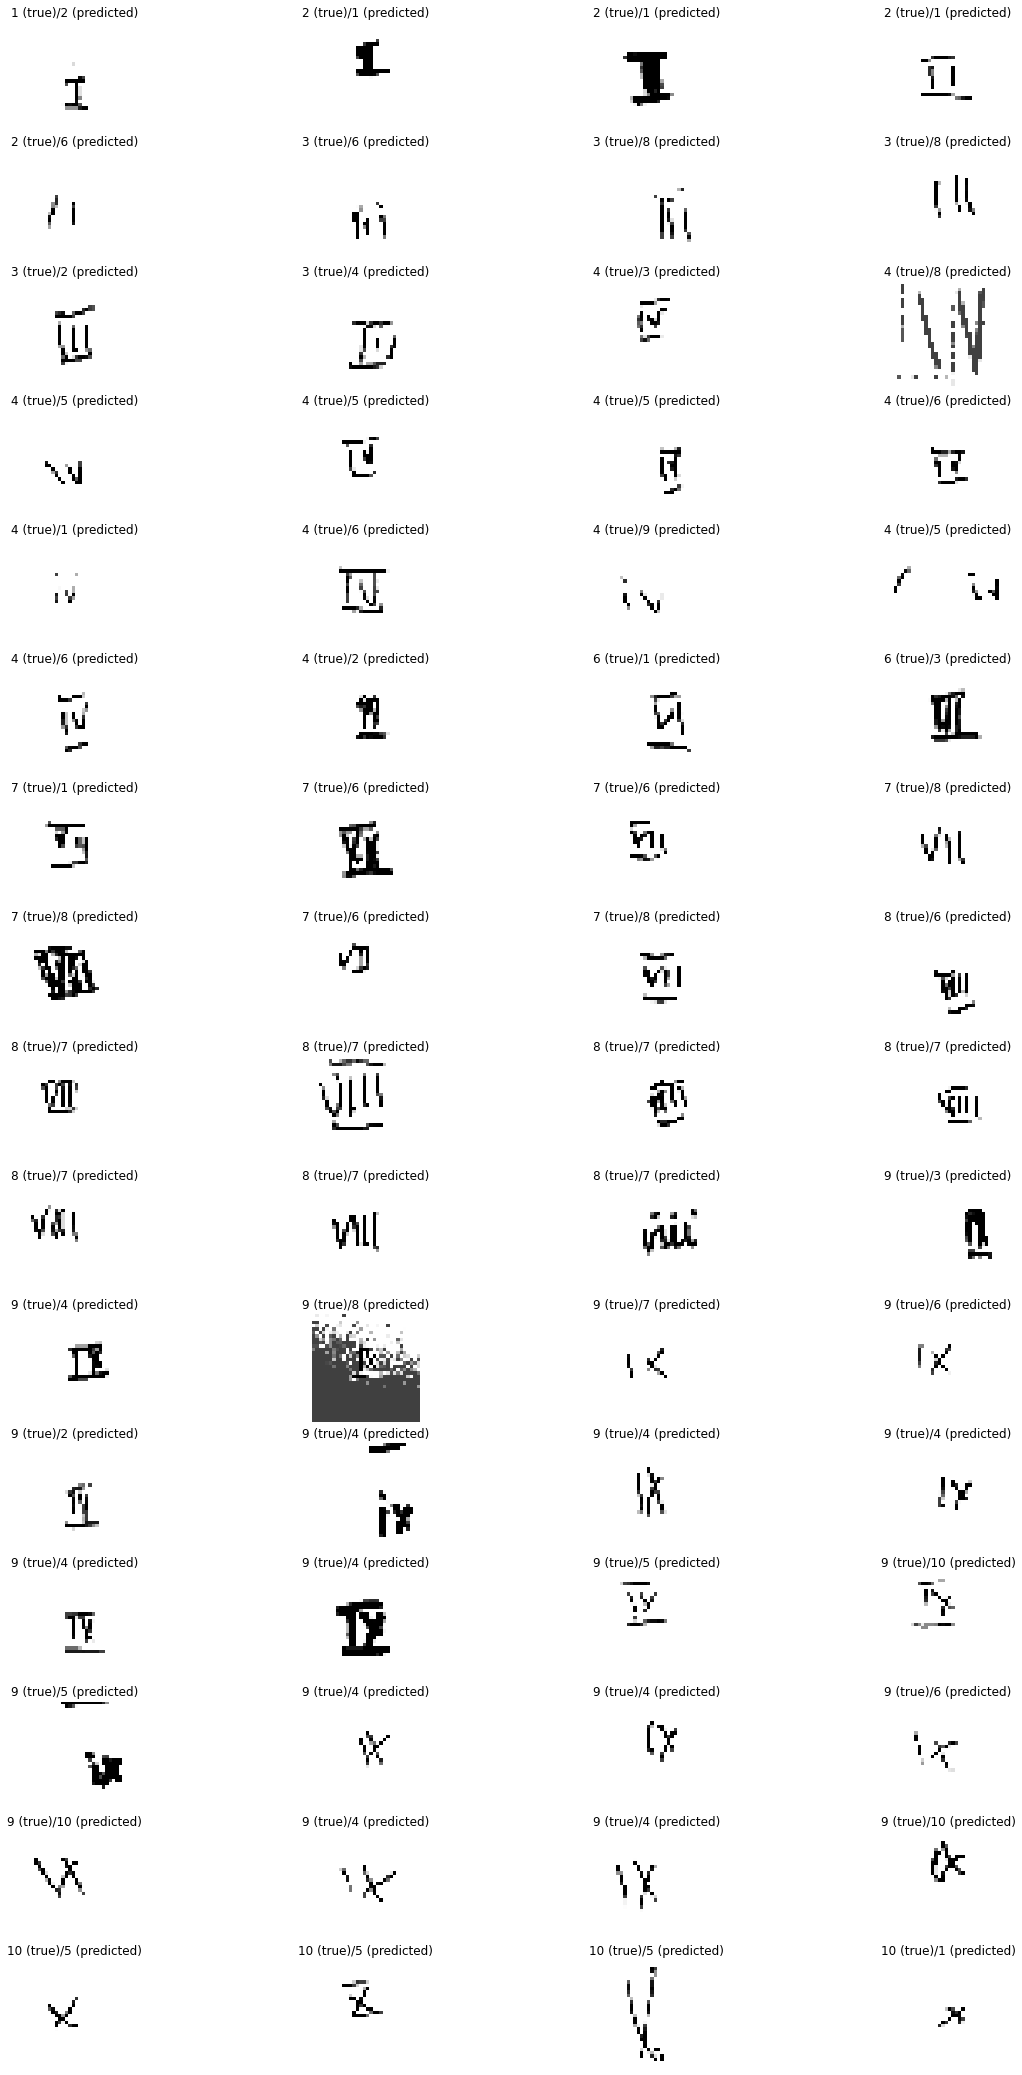

In [18]:
# Plots the incorrectly predicted validation images

fig_cols = 4
fig_rows = (len(eval_incorrect_predictions) // fig_cols) + 1

plt.figure(figsize=(20,40))

for idx, eval_incorrect_prediction in enumerate(eval_incorrect_predictions):
    ax = plt.subplot(fig_rows, fig_cols, idx + 1)
    plt.imshow(eval_incorrect_predictions[idx]["image"].numpy().astype("uint8"))
    plt.title(f"{eval_incorrect_predictions[idx]['y_true']} (true)/{eval_incorrect_predictions[idx]['y_pred']} (predicted)")
    plt.axis("off")

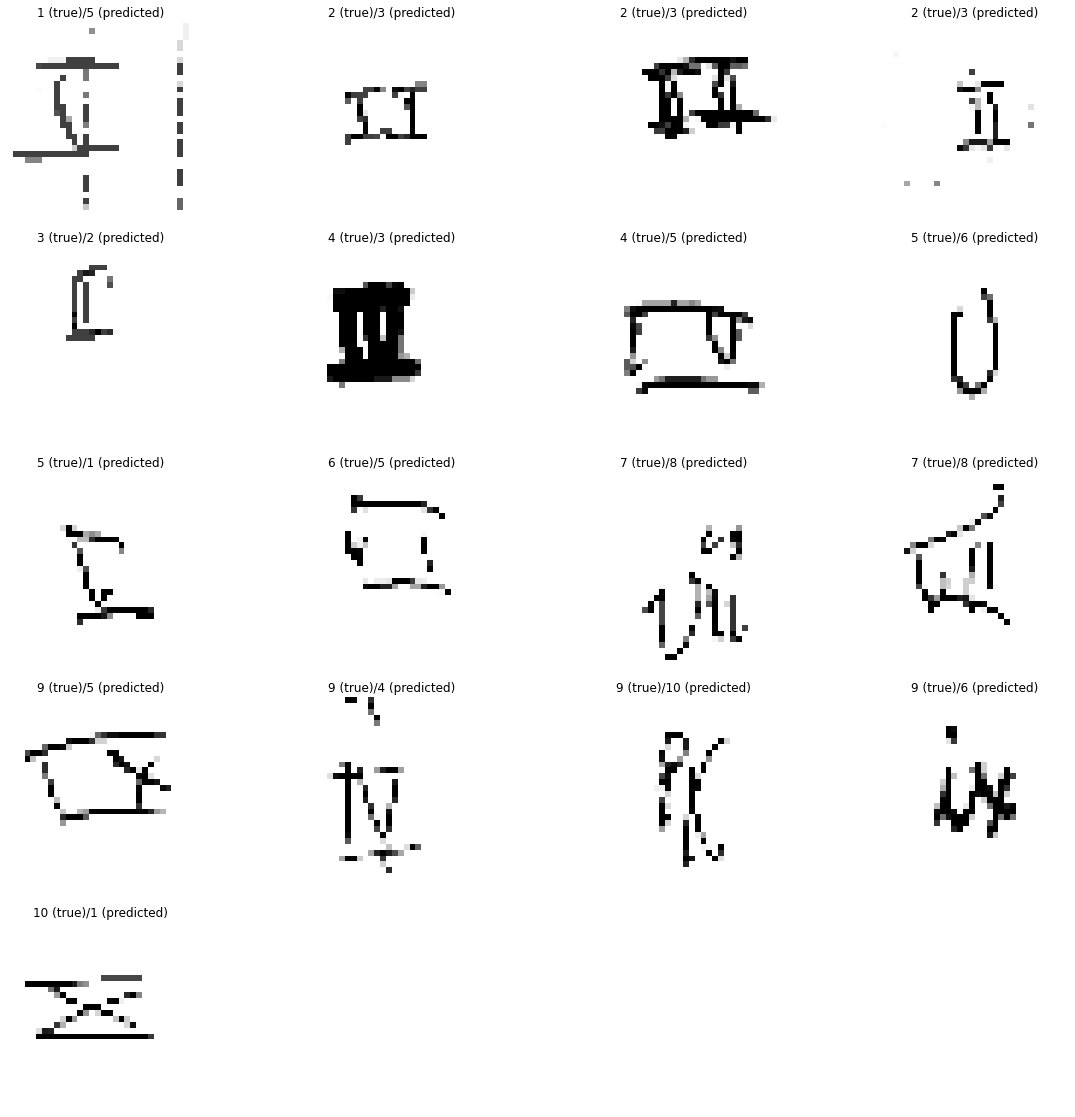

In [16]:
# Plots the incorrectly predicted test images

fig_cols = 4
fig_rows = (len(test_incorrect_predictions) // fig_cols) + 1

plt.figure(figsize=(20,20))

for idx, test_incorrect_prediction in enumerate(test_incorrect_predictions):
    ax = plt.subplot(fig_rows, fig_cols, idx + 1)
    plt.imshow(test_incorrect_predictions[idx]["image"].numpy().astype("uint8"))
    plt.title(f"{test_incorrect_predictions[idx]['y_true']} (true)/{test_incorrect_predictions[idx]['y_pred']} (predicted)")
    plt.axis("off")